In [8]:
import pandas as pd
import numpy as np
def load_data(csv_filepath):
    '''
    Load data from a csv file.

    :param csv_filepath: path of the .csv file containing the data to load/extract

    :return X: array of values associated with the inputs of the data contained in the .csv file
    :return Y: array of values associated with the labels of the data contained in the .csv file or None if the file does not contain labels 
    '''
    data = pd.read_csv(csv_filepath)
    # Headers' list:
    headers = data.columns # 'x' for inputs, 'y' for labels
    # Extract DataFrames based on the headers:
    x_data = data[headers[0]]
    # Convert an array-like string (e.g., '[0.02, 1.34\n, 2.12, 3.23\n]') 
    # into an array of floats (e.g., [0.02, 1.34, 2.12, 3.23]):
    X_data = [[float(feature) for feature in feature_vec.replace('[', '').replace(']', '').split()] for feature_vec in x_data]
    # convert data into numpy arrays
    X = np.array(X_data)

    if len(headers)>1:
        Y_data = data[headers[1]]
        Y = np.array(Y_data)
    else:
        Y = None
    return X, Y

jupyter nbconvert --to html --no-input homework1.ipynb

# Introduction

We have to provide a solution for two classification problems with different input spaces.
The analysis will start with the dataset with medium size.
We have no informations about the dataset that we're dealing with, we don't know what is the hypotesis so we have to start guessing and choose the model that performs better.

# Medium size dataset

In [9]:
medium_dataset = "./HW1_datasets_public/dataset1.csv"
X, y = load_data(medium_dataset)

The first thing that we should do is build intuition from the data.
A good way to build intuition is to visualize data.
A popular way to visualize data is to use T-SNE, what it essentially does is perform a non linear transformation of an N-dimensional space into a lower dimensional space of dimensione D.
Applying T-SNE directly to the dataset is slow with a runtime of approximately ~5 minutes per run on my machine and is very messy, preventing an approachable fine tuning.

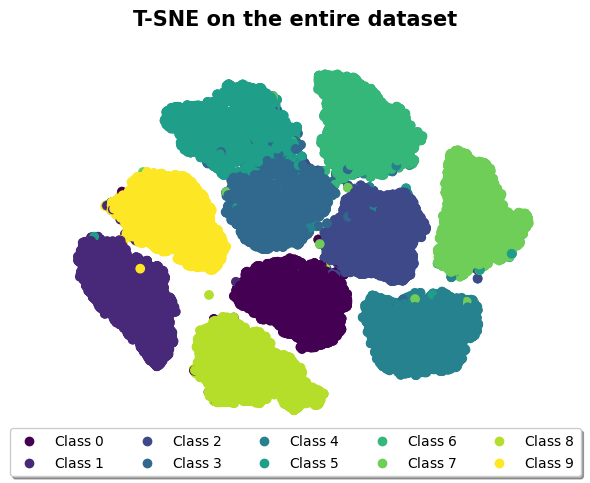

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

tsne_full = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30).fit_transform(X)
fig,ax = plt.subplots()
sct = ax.scatter(tsne_full[:,0],tsne_full[:,1],c = y)
fig.suptitle("T-SNE on the entire dataset", fontweight='bold',fontsize = 15)
ax.set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center',# bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)

plt.show()

As explained in the introduction we have no information about the the data, but our goal remains to get a model that best fits future unseen data, regardless of the information that we have.
A reasonable assumption is that the data is generated all by the same prior probability distribution, so in order to reduce time of T-SNE we could leverage this assumption and scale our dataset to be smaller but that follows the same prior distribution.

In [11]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_reduced, _, y_reduced, _ = train_test_split(X, y, test_size=0.9, random_state=42)



Another thing that slows down T-SNE is the fact that we have many attributes and maybe not all of them are useful.
To asses this claim we can use PCA, which stands for Principal Component Analysis.
PCA finds the variance for each axis and chooses them by variance (the greater the better), so the first is the axis with the largest variance, the second is an axis ortogonal to the first with largest variance and so on.
It is based on the intuition that planes with high variance also preserve the most information.
Each component has an information called explained variance ratio, that is the ration between the variance along a component and the dataset size.
We can choose arbitrarily the size of the dimensione that we want to reduce to, but we can choose to take only the first dimensions that are informative, i.e the set of components that carry the largest information let's assume 90% of the variance.

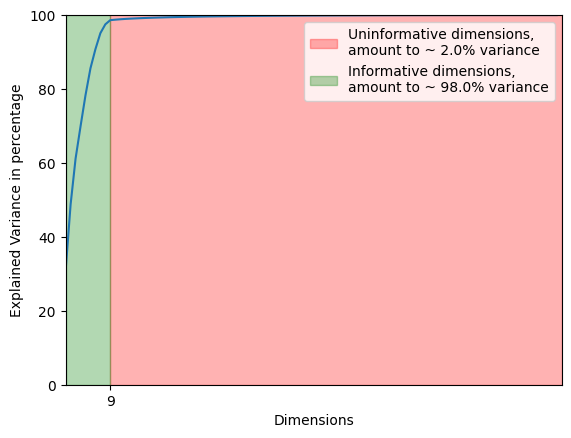

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_reduced_pca = pca.fit_transform(X_reduced)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
perc = 96
d  = np.argmax(cumsum >= perc) +1

plt.plot(cumsum)
#plt.plot(d,0,"ko") 
plt.axis([0,100,0,100])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in percentage")

# # Highlight the right part in orange
plt.fill_between(list(range(101)),y1 = 100, where =[i >=d for i in range(101)] , color='red', alpha=0.3, label=f'Uninformative dimensions,\namount to ~ {np.round(sum(pca.explained_variance_ratio_[d:]),2) * 100}% variance')
plt.fill_between(list(range(101)),y1 = 100,where =[i <= d for i in range(101)] , color='green', alpha=0.3, label=f'Informative dimensions,\namount to ~ {np.round(sum(pca.explained_variance_ratio_[:d]),2) * 100}% variance')
plt.xticks(ticks= [d])

#plt.yticks(ticks = cumsum[d])
# # Show the legend
plt.legend()
plt.show()

From the previous graph we inferred only 9 out of the 100 dimensions carry almost 98% oof the actual information about the data.
We can now inspect the T-SNE graph and see if changing the perplexity parameter causes some major changes.

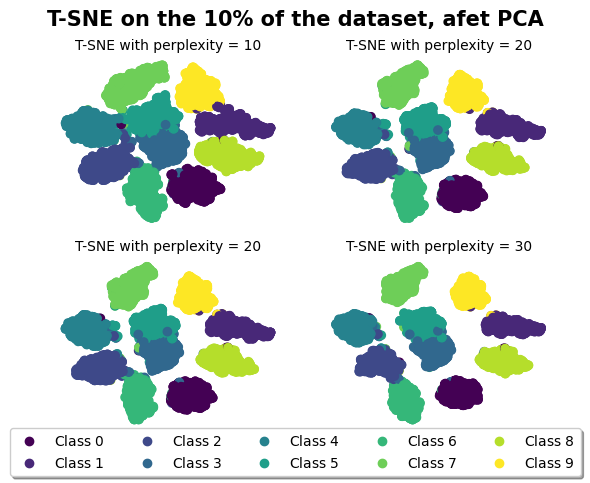

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)
# tsne = TSNE(n_components=2,random_state=0, perplexity=10).fit_transform(X_reduced_pca)
fig.suptitle(r"T-SNE on the 10% of the dataset, afet PCA", fontweight='bold',fontsize = 15)

# sct = ax[0][0].scatter(tsne[:,0],tsne[:,1],c = y_reduced)
for i in range(2):
    for j in range(2):
        tsne = TSNE(n_components=2,random_state=0, perplexity=10*(i+j+1)).fit_transform(X_reduced_pca)
        sct = ax[i][j].scatter(tsne[:,0],tsne[:,1],c = y_reduced)
        ax[i][j].set_title(f"T-SNE with perplexity = {10*(i+j+1)}",fontsize = 10)
        ax[i][j].set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center', 
          ncol=5, fancybox=True, shadow=True)
plt.show()

At an high enough level what we're interested about in T-SNE is the fact that it models high dimensional objects in a way that similar objects are modeled nearby and different objects are distant.
Let's keep this information for later, because it will be useful.
One last thing to keep for later is that the dataset is balanced.

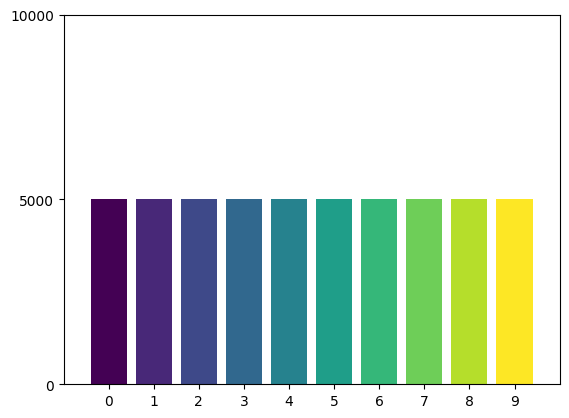

In [14]:
import matplotlib.pyplot as plt 
n_per_class = [sum(y == i) for i in range(10)]
n_class = np.unique(y) 
plt.bar(n_class,n_per_class,color=plt.cm.viridis(np.linspace(0, 1, len(set(y)))))
plt.axis([-1,len(n_class),0,max(n_per_class)*2])
plt.xticks(range(0,len(set(y))))
plt.yticks(range(0,(max(n_per_class)*2)+1,max(n_per_class)))
plt.show()

# plt.bar(,,height = max(n_per_class), width =1 )

## Model Selection

The first thing we can do is start trying different learning agorithms and choose the best based on the performance.
Generally speaking SVM is the best classifier, because it finds the maximum margin.
By picking the decision boundary with maxim margin we reduce the generalization error, and so our model will perform better on unseen data.
We don't know if the data is linearly separable or not, but using the kernel trick we could choose a kernel such that the algorithm will still choose a valid decision boundary.
But nothing is free and resorting to the kernel trick means that we're locked in the dual problem, thus we have to deal with a time complexity of $O(n^3)$, where $n$ is the number of samples.
This dataset is still small enough, and after the PCA we were able to reduce the number of attributes from 100 to 9, so using SVM is still manageable.
Since the dataset is balanced and we have no information about the objective that we're trying to maximize the accuracy gives us a great measure of the quality of the model.
We can use K-fold validation, in this way we can evaluate the model multiple times and decide do use the model that performs better on average.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

models = {
    "Linear SVM":make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="linear")),
    "Gaussian SVM": make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="rbf")),
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scores = {}
for modelname,model in models.items():
   scores.update({modelname:np.round(cross_val_score(model,X_train,y_train,cv =10),3)})
df = pd.DataFrame(scores)
df.rename(index={i:f"Iteration {i}" for i in df.index})
df.describe().iloc[[0,1,2,3,7]]

,Linear SVM,Gaussian SVM
count,10.000000,10.000000
mean,0.987300,0.988100
std,0.002669,0.002558
min,0.983000,0.984000
max,0.993000,0.993000


The SVM with a Gaussian kernel is the winner, since it outperfoms (even by a little) SVM with a linear kernel.
The precision however seems to be too high, fortunately when doing the K-fold validation we kept a portion of the dataset for test, using it we get an accuracy of ~98.6%, which is inline with the data collected during the k fold phase.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
model = make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="rbf"))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
#print(accuracy_score(y_pred,y_test))

0.9865454545454545


But we are not getting $100$, this is normal because in real life we always have to deal with noise, this also mean that somewhere we're making mistakes.
Mistakes take form of misclassifications, it comes in handy something called a confusion matrix.

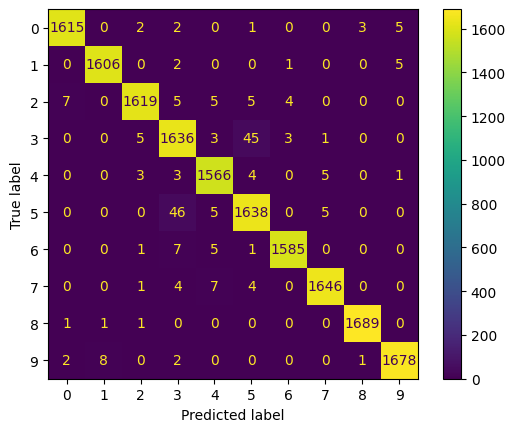

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
model = make_pipeline(StandardScaler(),PCA(n_components=9,random_state=42),SVC(kernel="rbf",random_state=42))
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()
plt.show()

We see that based on the confusion matrix we tend to misclassify mostly 3 and 5.
Let's get back to T-SNE plot with perplexity 30 and focus only on those two classes.

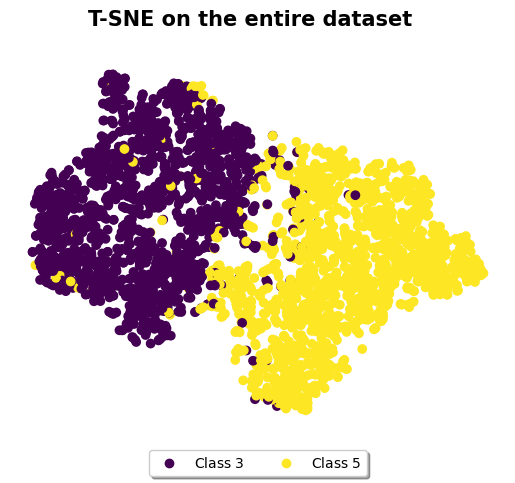

In [82]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

idx = np.logical_or(np.array(y_test) == 3,np.array(y_test) == 5)

X_classified = model['pca'].fit_transform(model['standardscaler'].fit_transform(X_test[idx]))
y_predicted = y_test[idx]

tsne_full = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30).fit_transform(X_classified)
fig,ax = plt.subplots()
sct = ax.scatter(tsne_full[:,0],tsne_full[:,1],c = y_predicted)
fig.suptitle("T-SNE on the entire dataset", fontweight='bold',fontsize = 15)
ax.set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center',# bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)

plt.show()

T-SNE can help us identify why SVM tend to make errors more frequently on $3$ and $5$, this is simply because they have features that make them close, so confusion arrises when trying to classify them.